In [1]:
print('https://www.whatismybrowser.com/detect/what-is-my-user-agent/')

https://www.whatismybrowser.com/detect/what-is-my-user-agent/


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os, sys
import shutil
import cv2
import warnings

from tqdm.notebook import tqdm 
from google.colab import drive
from datetime import datetime
from pytz import timezone
from glob import glob 

warnings.filterwarnings(action='ignore')
# 구글드라이브에 마운트 상대경로로 명시시에 오류가 나는 부분은 절대경로로 명시
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/collage')

# 구글 드라이브 내에 필요 패키지 설치 및 불러오기를 위한 경로 설정
try:
    os.mkdir('./packages')
except:
    print('-')
link_name = '/packages'
target = '/content/drive/My Drive/Colab Notebooks/collage/packages'
try:
  os.symlink(target, link_name)
except:
  os.chdir(target)
  os.remove(link_name)
  os.symlink(target, link_name)
sys.path.insert(0, link_name)

# 스크래핑에 필요한 헤더정보 정의
# 실행을 위해서는 각 환경에 맞는 유저에이전트 정보 필요 
headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}

Mounted at /content/drive
-


In [3]:
## 필요 패키지 설치
# !pip --version
# !pip install --target=$link_name --upgrade pip
# !pip install --target=$link_name --use-deprecated=legacy-resolver git+https://github.com/kakaobrain/pororo.git
# !pip install --target=$link_name konlpy
# !pip install --target=$link_name python-mecab-ko
# !pip install --target=$link_name kollocate
# !pip install --target=$link_name koparadigm1
# !pip install --target=$link_name g2pk
# !pip install --target=$link_name selenium
# !pip install --target=$link_name webdriver_manager
# !pip install --target=$link_name cairosvg
# !pip install --target=$link_name Django
!pip install Django
## 셀레니움 스크래핑에 필요한 크롬 드라이버 설치 
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.9 MB 4.1 MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Err:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
  504  Gateway Timeout [IP: 152.199.39.144 443]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,540 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Ge

In [4]:
# 설치한 자연어 처리모듈 뽀로로 및 직접정의한 py파일들 로드 / py파일에서 정의한 모든 주석은 각 py파일에 포함함
from pororo import Pororo

os.chdir('/content/drive/MyDrive/Colab Notebooks/collage')
import cairosvg 
import arrange
import scrap
import seg

# 자연어 처리 객체를 미리 생성
summ = Pororo(task="summarization", model="abstractive", lang="ko")
se = Pororo(task="sentence_embedding")
ner = Pororo(task="ner", lang="ko")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



In [5]:
# 산출물을 담을 딕셔너리 생성
def return_trend_dict():
  '''
  산출물을 담을 딕셔너리 생성 앞으로 return_dict라 칭할예정
  '''
  return {'keyword': None, 'issueKeyword': None, 'issueKeyword_kind': None, 'articles': None, 'links':None, 'title_picked':None, 'article_summary':None, 'img_name':None, 'img':None, 'img_coor':None}

In [6]:
# 시간 구분을 위함 
now = datetime.now(timezone('Asia/Seoul'))
datetime_text = str(now.strftime('%Y-%m-%d %H:%M'))
# 현재시간의 분을 00의 형식으로 바꿈
min = '00' if int(datetime_text[-2:])//10 < 1 else str(int(datetime_text[-2:])//10 * 10)
datetime_text = datetime_text[:-2]+min

keyword_dicts = []
keyword_now = scrap.scrapSignalKeyword()

print(f'{datetime_text} : {keyword_now}')
for idx, keyword in tqdm(enumerate(keyword_now)):
  dict_ = return_trend_dict()
  # 검색어에 해당하는 기사를 최신순으로 350자 이상의 기사를 8개까지 수집
  articles, links = scrap.scrapNaverNewsKeyword(keyword, article_num=10, headers=headers, sort='0', length=250)
  # 원검색어
  dict_['keyword'] = keyword
  # 검색어에 대응하는 (제목, 내용)의 리스트
  dict_['articles'] = articles
  # 앞으로 이미지 파일을 저장할 파일 이름
  dict_['img_name'] = str(idx) + '.png'
  # 기사들에 대응하는 링크들
  dict_['links'] = links
  keyword_dicts.append(dict_)

2022-09-02 11:20 : ['힌남노 경로', '8월 소비자물가 5.7%↑', '허위경력 거짓 해명', '량현 2년째 연락두절', '제니', '이찬원', '박셀바이오', '추가 확산 가능성', '입국 전 해외여행', '나지완']


0it [00:00, ?it/s]

In [7]:
# 오류시 대처를 위해 미리 원본 카피
okd = keyword_dicts.copy()

In [8]:
keyword_dicts = okd.copy()

In [9]:
# 자주 나오는 한자어들 대체
def character_replace(txt):
  '''
  txt : str / 대체될 텍스트
  '''
  per_dict = { '尹':'윤석열', '文':'문재인', '與': '국민의힘', '野': '더불어민주당'}
  for word, replacement in per_dict.items():
    txt = txt.replace(word, replacement)
  return txt

In [10]:
def find_issuekey(txt, check_all=False, ):
  '''
  텍스트에서 NER을 실시하여 이슈키워드들을 찾아내기 위한 함수
  인물을 우선적으로 추출

  txt : str / 이슈키워드를 찾아야하는 텍스트
  '''
  ner_result = ner(character_replace(txt))
  ner_person_list = [re[0] for re in ner_result if re[1]=='PERSON']
  ner_or_list = [re[0] for re in ner_result if re[1]=='ORGANIZATION']
  ner_arti_list = [re[0] for re in ner_result if re[1]=='ARTIFACT']
  ner_city_list = [re[0] for re in ner_result if re[1]=='CITY']
  # 인물 키워드 뿐만 아니라 기관이나 도시같은 키워드도 반환
  if check_all:
    if len(ner_person_list) > 0:
      for p in ner_person_list:
        if txt == p:
          return p, 'person'
      return ner_person_list[0], 'person'

    elif len(ner_or_list) > 0:
      for o in ner_or_list:
        if txt == o:
          return o, 'organization'
      return ner_or_list[0], 'organization'

    elif len(ner_arti_list) > 0:
      for a in ner_arti_list:
        if txt == a:
          return a, 'artifact'
      return ner_arti_list[0], 'artifact'

    elif len(ner_city_list) > 0:
      for c in ner_city_list:
        if txt == c:
          return c, 'city'
      return ner_city_list[0], 'city'
    else :
      return txt, '-'
  else:
    if len(ner_person_list) > 0:
      for p in ner_person_list:
        if txt == p:
          return p, 'person'
      return ner_person_list[0], 'person'
    else :
      return txt, '-'

In [11]:
print([k['issueKeyword'] for k in keyword_dicts])

[None, None, None, None, None, None, None, None, None, None]


In [12]:
# 각 검색어마다 이슈키워드와 키워드의 종류를 할당
for dict_ in tqdm(keyword_dicts):
  dict_['issueKeyword'], dict_['issueKeyword_kind'] = find_issuekey(dict_['keyword'])

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def find_impor_title_idx(dict_):
  '''
  리턴 딕셔너리를 받아 해당 제목들의 sentence embedding을 먼저 실시하고 
  cosine similarity를 구하여 스코어가 가장 높은 았던 제목의 인덱스를 반환하는 함수
  스코어가 가장 높은 제목이 현재의 이슈에 대한 내용을 담을 것이라는 가정하에 여러 기사들 사이에서 공통적인 내용을 의미하는 기사를 찾기 위함 
  공통적인 내용을 의미하는 기사를 앞으로 대표기사라고 칭하겠음

  dict_ : return_dict  
  '''

  titles = [character_replace(article[0].strip()) for article in dict_['articles']]
  titles_embedding = [se(t).reshape(1,-1) for t in titles]

  sims = []
  for i in range(len(titles_embedding)):
    cands = titles_embedding.copy()
    query = cands.pop(i)
    temp_num = 0
    for c in cands:
      temp_num += cosine_similarity(query, c)[0][0]
    sims.append(temp_num)
  max_ = max(sims)
  max_idx = sims.index(max_)

  return max_idx

In [14]:
def namukeyword_replace(txt):
  '''
  txt : str / 대체될 텍스트
  '''
  per_dict = { '검찰':'검찰청', '교직원공제회': '한국교직원공제회', '제주' : '제주특별자치도',  '경찰' : '대한민국 경찰청', '기상청':'대한민국 기상청'}
  for word, replacement in per_dict.items():
    txt = txt.replace(word, replacement)
  return txt

In [15]:
for dict_ in tqdm(keyword_dicts):
  max_idx = find_impor_title_idx(dict_)
  dict_['title_picked'] = max_idx
  if dict_['issueKeyword_kind']=='-':
    # 검색어에서 적절한 이슈키워드를 찾지 못한 경우 대표기사의 제목에서 이슈키워드를 찾음
    target_title = dict_['articles'][max_idx][0]
    dict_['issueKeyword'], dict_['issueKeyword_kind'] = find_issuekey(target_title, check_all=True)
    dict_['issueKeyword'] = namukeyword_replace(dict_['issueKeyword'])

  # 대표기사의 본문의 요약문을 생성
  dict_['article_summary'] = summ(dict_['articles'][max_idx][1],
                                  beam=5, 
                                  len_penalty=3,
                                  no_repeat_ngram_size=3,
                                  top_k=50,
                                  top_p=0.7,
                                  temperature=1.5
                                  )
  
  if dict_['issueKeyword_kind']=='-':
    # 검색어, 대표기사의 제목에서 이슈키워드를 찾지 못한경우 대표기사의 요약문에서 이슈키워드를 찾음
    target_content = dict_['article_summary']
    dict_['issueKeyword'], dict_['issueKeyword_kind'] = find_issuekey(target_content, check_all=True)
    dict_['issueKeyword'] = namukeyword_replace(dict_['issueKeyword'])
  if dict_['issueKeyword_kind']=='-':
    dict_['issueKeyword'] = dict_['keyword']

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
print([k['issueKeyword'] for k in keyword_dicts])

['힌남노 경로', '8월 소비자물가 5.7%↑', '김건희', '량현', '제니', '이찬원', '박셀바이오', '정부', '정부', '나지완']


In [17]:
# 이미지를 가지고올 사이트의 태크를 찾아냄
tag = scrap.find_img_tag(headers)

try:
    os.mkdir('./result')
except:
    print('-')
os.chdir('/content/drive/MyDrive/Colab Notebooks/collage/result')
try:
    os.mkdir('./'+datetime_text)
except:
    pass
# 기사와 이미지를 저장할 경로생성
try:
    os.mkdir(f'./{datetime_text}/img')
    os.mkdir(f'./{datetime_text}/txt')
except:
    pass
# 각 검색어에 대응하는 나무위키검색키워드에 따라서 나무위키에서 이미지 크롤링 및 미리 스크래핑했던 기사들 파일로 저장
for i,dict_ in enumerate(keyword_dicts):
    print(f"{dict_['keyword']} -> {(dict_['issueKeyword'])}")
    try:
        os.mkdir(f"./{datetime_text}/txt/{dict_['keyword']}")
    except:
        pass
    txt_path = f"./{datetime_text}/txt/{dict_['keyword']}"
    scrap.saveArticles(dict_['articles'], txt_path)
    img_path = f'./{datetime_text}/img/{i}.png'
    try:
      img = scrap.scrapNamuImg(dict_['issueKeyword'],img_path, headers=headers, tag=tag, namuKeyword_kind=dict_['issueKeyword_kind'])
      if img is None and dict_['issueKeyword_kind'] == 'person':
        scrap.save_article_img(dict_['links'][0], headers, img_path)
    except:
        pass

-
힌남노 경로 -> 힌남노 경로
8월 소비자물가 5.7%↑ -> 8월 소비자물가 5.7%↑
허위경력 거짓 해명 -> 김건희
https://w.namu.la/s/bf7b5240bd66db9bc4abccb2008a1a4a2e0297aea25e3ef5eff95e71d432ca335591753fbd77e9bb61355260db209509dfed3473f21f873feed8c5c217fa4ef8465f5cedb681ba46b640cc2b2b23d64f2ae152609cc7ce0ddf0666658905db0cbfcbd5aa37c7379d078273f1a6a01926
량현 2년째 연락두절 -> 량현
https://w.namu.la/s/44c9509256478c2209d18c883e701d7c3243dacf54f912eb81201c85c4f1c8aa385762f53a3b9f0da7b1ff618c0b262ab1c6585260cb6983695366c3a5d92ea85e1b02a7bee2e5ce38eaf8b6ff0ab4bd92dac0b4e02334f5b426cc906d6b8216
제니 -> 제니
https://mimgnews.pstatic.net/image/144/2022/09/01/0000834295_001_20220901095203717.jpg?type=w540
이찬원 -> 이찬원
https://w.namu.la/s/057050a5b2fdd106a5cede100ace272890dd84699b518dadbb36dc7f429b07a12c95cb8a3bbb4542996033e7074184b2d8ff9a318655157c1d41726490cd10c599cfe9dbd375452fcf8dee64a4c7ab177a14201e10f3e419c458b431319d992c8b528ac4ab0a4e7f46f1a481619422e8
박셀바이오 -> 박셀바이오
https://w.namu.la/s/4297182369ef40baeb0c881e20e5949b20a11070f5296f37f94df971a

In [18]:
# 저장 경로생성
try:
    os.mkdir('./'+datetime_text+'/segmentation')
except:
    print('-')
# 기학습한 모델 로드
model_present_path = '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/model_weight/full_weight.h5'
model_present = tf.keras.models.load_model(model_present_path)
face_detector = arrange.make_classifier('/content/drive/MyDrive/Colab Notebooks/collage/haarcascade_frontalface_alt.xml')

In [19]:
# 모델로 키워드가 사람인 경우에는 세그멘테이션 진행 이후 얼굴을 근처로 크롭
# 아닌 경우 (단체의 로고 따위) return_dict에만 저장
for dict_ in tqdm(keyword_dicts):
  load_path = f'./{datetime_text}/img/{dict_["img_name"]}'
  save_path = f'./{datetime_text}/segmentation/{load_path.split("/")[-1]}'
  if dict_['issueKeyword_kind'] == 'person':
    try:
      temp_img = seg.segSave(model_present, load_path, save_path=None)
      temp_img = arrange.crop_blank(temp_img)
      temp_img = arrange.crop_near_face(temp_img, face_detector)
      if len(np.unique(dict_['img'])) == 1:      
        pass
      dict_['img'] = temp_img
      cv2.imwrite(save_path, temp_img)

    except:
      pass
  else:
    try:
      temp_img = cv2.imread(load_path, cv2.IMREAD_UNCHANGED)
      dict_['img'] = temp_img
    except:
      pass

  0%|          | 0/10 [00:00<?, ?it/s]

얼굴 인식이 한 명 초과로 감지됨.
얼굴 인식이 되지 않음
얼굴 인식이 한 명 초과로 감지됨.


In [20]:
img_list = [dict_['img'] for dict_ in keyword_dicts if dict_['img'] is not None]
img_names = [dict_['img_name'] for dict_ in keyword_dicts if dict_['img'] is not None]

# 이미지들의 사이즈를 순위정보에 따라 리사이즈
image_resize = arrange.resize_after_crop(img_list)
# 이미지들, 배경간의 구분을 위해서 그림자를 만듦
image_resize_edge = [arrange.shadow(img) for img in image_resize]
# 이미지들의 초기위치정보를 설정
image_map = arrange.mapping_after_resize(image_resize_edge, ground_region=[0, 1, 0.1, 1])
# 이미지들의 위치를 조정하고 평가함수가 가장 높은 결과를 리턴
index = arrange.decision_position(image_map, more=True, walk=30, trace=False,)
# 웹에서 사용될 위치정보로변환
b_index = arrange.web_index(image_resize_edge, index)

In [21]:
# 각 이미지 좌표를 return_dict에 저장
coor = b_index.copy()
for dict_ in tqdm(keyword_dicts):
  if dict_['img'] is None:
    pass
  else:
    dict_['img_coor'] = coor.pop(0)
# 리사이즈, 그림자를 적용한 이미지들을 이미지파일로 저장, 즉 웹에 들어갈 이미지를 최종저장
try:
    os.mkdir('./'+datetime_text+'/final_img')
except:
    print('-')
for name, img in zip(img_names, image_resize_edge):
  cv2.imwrite('./'+datetime_text+'/final_img/'+name, img)

  0%|          | 0/10 [00:00<?, ?it/s]

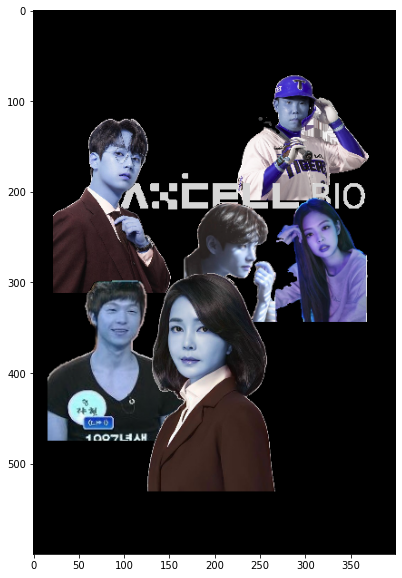

In [22]:
# 배치완료 이미지를 확인하기
background = np.zeros((600, 400, 3))
image_resize_edge.append(background)

after_padd = arrange.padding_position(image_resize_edge,index);
final_image, final_record = arrange.projection_image(after_padd)
cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/final.png', final_image)
plt.figure(figsize=(10,10))
plt.imshow(final_image)

In [23]:
# 카드뉴스에 사용될 대표기사의 이미지를 저장
try:
    os.mkdir('./'+datetime_text+'/article_img')
except:
    print('-')

for dict_ in tqdm(keyword_dicts):
  url = dict_['links'][dict_['title_picked']]
  im = scrap.save_article_img(url, headers=headers, save_path='./'+datetime_text+'/article_img/'+dict_['img_name'])

  0%|          | 0/10 [00:00<?, ?it/s]

https://imgnews.pstatic.net/image/008/2022/09/02/0004790427_001_20220902065503838.jpg?type=w647
https://imgnews.pstatic.net/image/586/2022/09/02/0000044244_001_20220902110201833.jpg?type=w647
https://imgnews.pstatic.net/image/016/2022/01/02/20220102000100_0_20220102102502162.jpg?type=w647
https://mimgnews.pstatic.net/image/415/2022/09/02/202209021059427510_1_20220902110101495.jpg?type=w540
https://ssl.pstatic.net/mimgnews/image/112/2022/09/01/202209010701256964772_20220901070135_02_20220901124801569.jpg?type=w540
https://mimgnews.pstatic.net/image/003/2022/08/29/NISI20220829_0001072779_web_20220829135504_20220829140318882.jpg?type=w540
https://imgnews.pstatic.net/image/421/2022/08/30/0006304959_001_20220830095101546.jpg?type=w647
https://imgnews.pstatic.net/image/003/2022/09/02/NISI20220902_0001076377_web_20220902084926_20220902085503899.jpg?type=w647
https://imgnews.pstatic.net/image/119/2022/09/01/0002635429_001_20220901060003616.jpeg?type=w647
https://imgnews.pstatic.net/image/109/2

In [24]:
from distutils.dir_util import copy_tree
# 웹구성에 사용될 이미지들을 웹에 적용가능한 경로로 복사 
copy_tree(f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/final_img', "/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/final_img")
copy_tree(f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/article_img/', "/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/")

['/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/0.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/1.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/2.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/3.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/4.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/5.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/6.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/7.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/8.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/9.png']

In [25]:
import pandas as pd

def last_return(dict_):
  """
  마지막으로 웹에 적용할 최종리턴 값을 pandas dataframe에 쌓기 위한 함수

  dict_ : return_dict
  """
  last_return_dict = {
      'keyword' : dict_['keyword'],
      'key' : dict_['issueKeyword'],
      'article_link' : dict_['links'][dict_['title_picked']],
      'article_title' : dict_['articles'][dict_['title_picked']][0].strip(),
      'article_summary' : dict_['article_summary'],
      'img' : f'../../../static/img/final_img/{dict_["img_name"]}',
      'img_x' : dict_['img_coor'][0],
      'img_y' : dict_['img_coor'][1],
      'img_article' : f'../../../static/img/article_img/{dict_["img_name"]}',
      'time' : datetime_text
  }
  return last_return_dict
# 웹에 리턴할 csv생성
ret_csv = pd.DataFrame()
# 이미지 좌표가 생성된 즉 이미지를 잘가지고온 키워드들을 웹에 리턴할 csv에 추가
for kd in [last_return(dict_) for dict_ in keyword_dicts if dict_['img_coor'] is not None]:
  ret_csv = ret_csv.append(kd, ignore_index=True)

# 웹에 보낼 경로에 ret_csv를 저장
ret_csv.to_csv('/content/drive/MyDrive/Colab Notebooks/collage/django/collage/collageapp/csv/collage.csv', index=False)

keyword_csv = pd.DataFrame({'keyword': keyword_now})
keyword_csv.to_csv('/content/drive/MyDrive/Colab Notebooks/collage/django/collage/collageapp/csv/keyword.csv', index=False)

In [27]:
# django를 구동할 폴더로 경로이동
from google.colab.output import eval_js

os.chdir('/content/drive/MyDrive/Colab Notebooks/collage/django/collage')
print(eval_js("google.colab.kernel.proxyPort(8000)"))

https://ilqvloawagm-496ff2e9c6d22116-8000-colab.googleusercontent.com/


In [28]:
# 웹구동
!python manage.py runserver 8000

Watching for file changes with StatReloader
Performing system checks...

System check identified no issues (0 silenced).
September 02, 2022 - 02:34:29
Django version 3.2.15, using settings 'collage.settings'
Starting development server at http://127.0.0.1:8000/
Quit the server with CONTROL-C.
[02/Sep/2022 02:34:40] "GET / HTTP/1.1" 200 1926
[02/Sep/2022 02:34:41] "GET /static/css/2.css HTTP/1.1" 200 995
[02/Sep/2022 02:34:42] "GET /static/css/FredokaOne-Regular.ttf HTTP/1.1" 404 1848
Not Found: /favicon.ico
[02/Sep/2022 02:34:42] "GET /favicon.ico HTTP/1.1" 404 2355
[02/Sep/2022 02:34:50] "GET /about HTTP/1.1" 200 12588
[02/Sep/2022 02:34:51] "GET /static/img/final_img/2.png HTTP/1.1" 200 56437
[02/Sep/2022 02:34:51] "GET /static/img/final_img/4.png HTTP/1.1" 200 57256
[02/Sep/2022 02:34:51] "GET /static/img/final_img/5.png HTTP/1.1" 200 40331
[02/Sep/2022 02:34:51] "GET /static/css/1.css HTTP/1.1" 200 3988
[02/Sep/2022 02:34:51] "GET /static/img/final_img/6.png HTTP/1.1" 200 5950
[02/